<a href="https://colab.research.google.com/github/leunco/Hands_On_MachineLearning/blob/main/3%EC%A3%BC%EC%B0%A8/%EA%B9%80%EB%8B%A4%EC%98%81/Chap7_%EC%95%99%EC%83%81%EB%B8%94%ED%95%99%EC%8A%B5%EA%B3%BC_%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

## Chap7. 앙상블 학습(Ensemble Learning)과 랜덤 포레스트(Random Forest)
분류나 회귀 모델같은 일련의 예측기들로부터 예측을 수집하면 **가장 좋은 모델 하나보다 더 좋은 예측**을 얻을 수 있을 것이다. 일련의 예측기를 앙상블이라고 부르기 때문에 여러 개의 예측기를 이용하는 것을 **앙상블 학습**(Ensemble Learning)이라고 하고, 앙상블 학습 알고리즘을 앙상블 방법이라고 한다.

예를 들어 훈련 세트로부터 무작위로 각기 다르 서브셋을 만들어서 일련의 결정 트리 분류기를 훈련시킬 수 있다. 예측을 하기 위해서는 **모든 개별 트리의 예측**을 구하고, **가장 많은 선택을 받은 클래스를 예측으로** 정한다. **결정 트리의 앙상블**을 **랜덤 포레스트**(Random Forest)라고 하며, 간단하지만 가장 강력한 머신러닝 알고리즘 중 하나이다.

**랜덤 포레스트, 배깅, 부스팅, 스태킹** 등 가장 인기 있는 앙상블 방법들을 살펴볼 것이다.

## 7.1 투표 기반 분류기
예를 들어 정확도가 80%인 분류기를 여러 개 훈련시켰다고 가정한다면, 로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, K-최근접 이웃 분류기 등이 있을 수 있다.

이를 이용하여 간단하게 더 좋은 분류기를 만드는 방법은 각 분류기의 예측을 모아서 **가장 많이 선택된 클래스를 예측**하는 것이다. 이렇게 **다수결 투표**로 정해지는 분류기를 **직접 투표(hard voting) 분류기**라고 한다.


이러한 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높은 경우가 많다.

혹시 각 분류기가 랜덤 추측보다 조금 더 높은 성능을 내는 약한 학습기일지라도 충분하게 많고 종류가 다양하다면 앙상블은 높은 정확도를 내는 강한 학습기가 될 수 있다.

앙상블 방법은 **예측기가 가능한 서로 독립적일 때 최고의 성능**을 발휘한다. 다양한 분류기를 얻는 방법은 **각기 다른 알고리즘**으로 학습시키는 것으로, 이렇게 하면 **매우 다른 종류의 오차**를 만들 가능성이 높기 때문에 **앙상블 모델의 정확도를 향상**시킨다.

다음은 여러 분류기를 조합하여 **사이킷런의 투표 기반 분류기** `VotingClassifier`를 만들고, moons 데이터셋을 훈련시키는 코드이다.

`VotingClassifier`는 `estimators` 인자로 앙상블하는 분류기를 사용할 이름과 불러들인 클래스를 튜플 형태로 입력한다. 그리고 직접 투표 방식인 다수결 방법을 사용하므로 `voting='hard'`로 지정한다.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [ ]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.896


각 분류기들의 정확도를 측정한 결과, 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높다.

모든 분류기가 `predict_proba()` 메서드가 있어서 **각 클래스의 확률을 예측**할 수 있으면, 개별 분류기의 클래스별 예측 확률의 평균을 구하여 **확률이 가장 높은 클래스**를 예측할 수 있다.

이러한 방식을 사용하는 분류기를 **간접 투표(soft voting) 분류기**라고 하며, 확률이 높은 투표에 더 비중을 두기 때문에 **직접 투표 방식보다 성능이 높다.**

간접 투표 분류기를 사용하기 위해서는 모든 분류기가 클래스의 확률을 추정할 수 있어야 하며, `voting='soft'`로 지정하면 된다.

예를 들어 앞의 분류기 중에서 `SVC`는 기본값에서는 클래스 확률을 제공하지 않으므로 `probability` 매개변수를 `True`로 지정해야 하며, 이렇게 하면 `predict_proba()` 메서드를 사용할 수 있다.

앞의 코드를 간접 투표 방식을 사용하도록 변경하고 간접 투표 분류기의 정확도를 측정한다.


In [ ]:
svm_clf = SVC(probability=True, random_state=42)
voting_soft_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
voting_soft_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [ ]:
y_pred = voting_soft_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

앞선 직접 투표 분류기의 정확도는 0.904였고, 간접 투표 분류기의 정확도는 0.912이다.

이로부터 확률이 높은 투표에 더 비중을 두는 **간접 투표 방식이 직접 투표 방식보다 성능이 더 높다**는 사실을 다시 확인할 수 있다.

## 7.2 배깅(Bagging)과 페이스팅(Pasting)
다양한 분류기를 만드는 또 다른 방법은 **같은 알고리즘**을 사용하되 **훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습**시키는 것이다.

훈련 세트에서 **중복을 허용하여 샘플링**하는 방식을 **배깅**이라고 한다. 배깅(bagging)은 bootstrap aggregating의 줄임말로, 통계학에서는 중복을 허용한 리샘플링(resampling)을 **부트스트래핑**(bootstraping)이라고 한다

이와 반대로 훈련 세트에서 **중복을 허용하지 않고 샘플링**하는 방식을 **페이스팅**이라고 한다.

배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐서 사용할 수 있다. 그러나 오직 배깅만이 하나의 예측기를 위해 같은 훈련 샘플을 여러번 샘플링할 수 있다.

아래의 그림은 무작위 중복을 허용해서 뽑는 배깅 방식을 그림으로 나타낸 것이다.


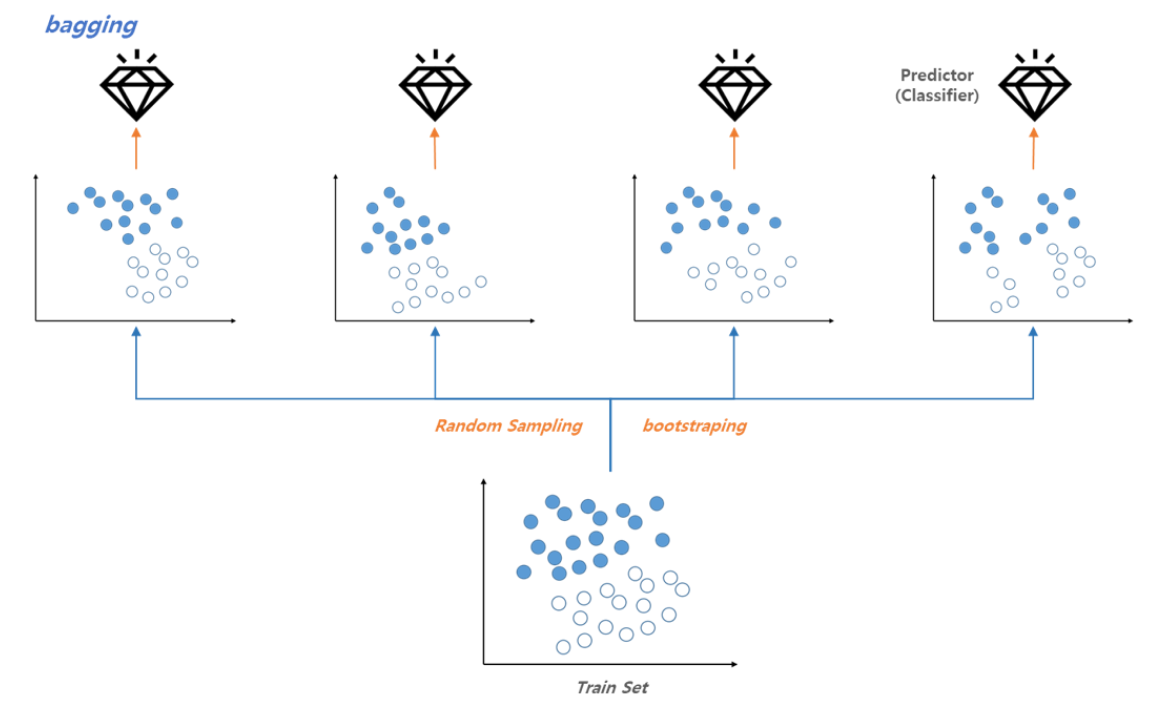

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다.

각 모델이 학습된 후에 새로운 데이터에 대해서는  
- **분류**(classification)일 때는 **최빈값**(mode) 즉 '투표 기반 분류기'와 동일하게 가장 많은 예측 클래스로 앙상블이 예측한다.
- **회귀**(regression)일 경우에는 **각 분류기의 예측값의 평균**을 계산하여 평균값을 예측값으로 한다.

각각의 예측기는 전체 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만, 앙상블을 통하면 편향과 분산이 모두 감소한다. 일반적으로 **앙상블의 결과**는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교하여 **편향은 비슷하지만 분산은 줄어든다.**

### 7.2.1 사이킷런의 배깅과 페이스팅
사이킷런은 배깅과 페이스팅을 간편하게 사용할 수 있도록 분류일 때는 `BaggingClassifier`를, 회귀일 때는 `BaggingRegressor`를 제공한다.

아래의 예제는 moons 데이터셋에 `BaggingClassifier`를 이용하여 500개의 결정 트리 분류기 모델을 만들어서 앙상블을 훈련시키는 예제이다.

각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택하는 **배깅** 방식으로 생성된 100개의 샘플로 훈련된다. 이를 위해서는 `BaggingClassifier` 매개변수에 `bootstrap=True`로 지정해야 하며, 만약 **페이스팅**을 사용하려면 `bootstrap=False`로 지정하면 된다.

`n_jobs` 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정하는 것으로, -1을 지정하면 사용가능한 모든 코어를 사용한다.

In [ ]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

> 단 하나의 Decision Tree를 사용할 경우

먼저 배깅을 이용한 앙상블 학습이 얼마나 더 성능이 좋은지 비교하기 위해, 단 하나의 결정 트리 문류기 모델을 이용해 moons 데이터셋에 적용한다.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred_tree)

0.856

> Bagging을 이용한 앙상블 학습

이번에는 `BaggingClassifier`를 이용해 500개의 결정 트리 분류기를 사용하는 앙상블 모델을 만든다.

이때 `BaggingClassifier`는 사용하는 알고리즘 모델이 **각 예측 클래스의 확률을 추정할 수 있으면**, 직접 투표(hard voting)대신 **간접 투표**(soft voting) 방식을 사용한다.

In [ ]:
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, max_samples=100,
    bootstrap=True, n_jobs=-1, random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred_tree = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred_tree)

0.904

하나의 결정 트리 분류기를 사용한 정확도는 0.856이고, 500개의 결정 트리 분류기를 사용한 앙상블 모델의 정확도는 0.904로 더 좋은 성능을 보인다.

아래의 왼쪽 그림은 하나의 결정 트리 분류기에 대한 결정 경계이고, 오른쪽 그림은 배깅을 이용한 앙상블 트리에 대한 결정 경계를 나타낸 것이다.

왼쪽 그림은 오른쪽 그림에 비해 데이터를 따라 심하게 구불구불하게 나타나므로, 앙상블 모델이 일반화가 더 잘 되었다는 것을 확인할 수 있다. 앙상블은 비슷한 편향에서 더 작은 분산을 만든다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

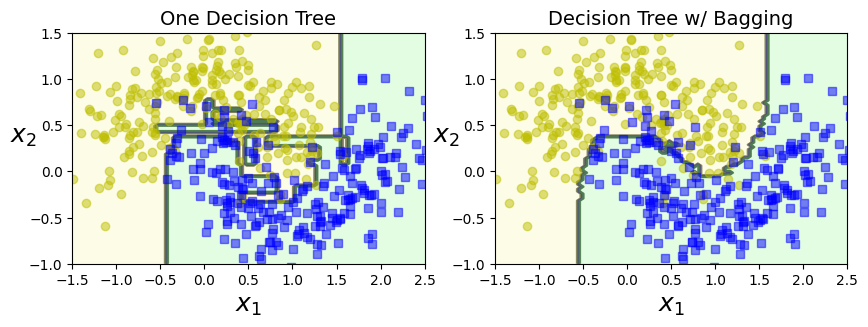

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("One Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Tree w/ Bagging", fontsize=14)
plt.show()

중복을 허용한 리샘플링인 부트스트래핑은 **각 예측기가 학습하는 서브셋의 다양성을 증가**시키므로, **배깅이 페이스팅보다 편향이 조금 더 높다.** 하지만 다양성을 추가한다는 것은 예측기들 간의 상관관계를 줄이므로 **앙상블의 분산을 감소시킨다.**

전반적으로 배깅이 더 나은 모델을 만들기 때문에 보통 **페이스팅보다 배깅을 더 선호한다.**

### 7.2.2 oob 평가
배깅은 중복을 허용한 부트스트래핑 방식이기 때문에 전체 학습 데이터셋에서 어떤 샘플은 하나의 예측기를 위해 여러번 샘플링되고, 어떤 것은 전혀 선택되지 않을 수 있다. `BaggingClassifier`는 기본값으로 중복을 허용하여`bootstrap=True`) 훈련 세트의 크기만큼인 m개의 샘플을 선택한다.

이는 평균적으로 학습 단계에서 전체 학습 데이터셋 중 63% 정도만 샘플링 되는 것을 의미한다. **나머지 37% 데이터 샘플들은 샘플링 되지 않는**데, 이 샘플들을 **oob(out-of-bag) 샘플**이라고 한다. 예측기마다 남겨진 37%의 샘플은 모두 다르다.

앙상블 모델의 **학습** 단계에서는 **oob 샘플이 사용되지 않기 때문에**, 별도의 검증 세트를 사용하지 않고 이러한 **oob 샘플을 검증 세트나 교차검증에 사용**할 수 있다.



사이킷런에서는 `BaggingClassifier`의 인자를 `oob_score=True`로 지정하면 **학습이 끝난 후에 자동으로 oob 평**가를 수행한다.

평가 점수 결과는 `oob_score_` 변수에 저장되어 있다.

oob 평가 결과를 보면 이 `BaggingClassifier`가 테스트 세트에서 약 89%의 정확도를 얻을 것으로 보인다.


In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

또한 아래의 코드와 같이 `oob_decision_function_` 변수를 사용하면 **oob 샘플에 대한 결정 함수값**도 확인할 수 있다.

이 경우 기반이 되는 예측기가 `predict_proba()` 메서드를 가지고 있으므로 결정 함수는 각 훈련 샘플의 클래스 확률을 반환한다.

각 클래스별 확률을 살펴보면 oob 평가가 첫번째 훈련 샘플이 양성 클래스에 속할 확률을 67%로 추정하고 있다는 것을 알 수 있다.

In [ ]:
bag_clf.oob_decision_function_[:5]

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## 7.3 랜덤 패치와 랜덤 서브스페이스
`BaggingClassifier`는 **특성 샘플링**을 지원하며, `max_features, bootstrap_features` 두 매개변수로 조절된다.

샘플이 아닌 **특성에 대한 샘플**링으로, 따라서 각 예측기는 **무작위로 선택한 입력 특성의 일부분으로 훈련**된다. 이 기법은 매우 고차원의 데이터셋을 다룰 때 유용하다.

학습 데이터 셋의 샘플 및 특성 샘플링 사용 유무에 따라 두 종류로 나눌 수 있다.
- **랜덤 패치 방식**(Random Patches method): **특성과 샘플을 모두 샘플링**하는 방식
- **랜덤 서브스페이스 방식**(Random Subspace method): **샘플은 모두 사용**하고, **특성만 샘플링**하는 방식
 - 훈련 샘플 모두 사용: `bootstrap=False`이고, `max_samples=1.0`
 - 특성은 샘플링: `bootstrap_features=True` 그리고 `max_features`는 1.0보다 작은 값

특성 샘플링은 더 다양한 예측기를 만들며 편향은 늘어나지만 분산을 낮출 수 있다.

## 7.4 랜덤 포레스트 (Random Forest)
**랜덤 포레스트**는 일반적으로 **배깅** 방법을 적용한 **결정 트리의 앙상블**이다.

앞의 예제에서는 `BaggingClassifier`에 `DecisionTreeClassifier`를 인자로 넣었다. 그러나 사이킷런에서는 랜덤 포레스트를 간편하게 쓸 수 있도록 `RandomForestClassifier`를 제공하고 있다.

다음의 코드는 최대 16개의 리프 노드를 갖는 500개의 결정 트리로 이루어진 랜덤 포레스트 분류기를 학습시키는 코드이다.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

`RandomForestClassifier`는 몇가지 예외를 제외하고, 트리 성장의 조절을 위한 `DecisionTreeClassifier`의 매개변수와 앙상블 자체를 제어하는데 필요한 `BaggingClassifier`의 매개변수를 모두 가지고 있다.

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에 최선의 특성을 찾는 대신에, **무작위로 선택한 특성 후보들 중에서 최적의 특성을 찾는 식**으로 무작위성을 더 주입한다.

이는 결국 트리를 더욱 다양하게 만들고, 편향은 늘어나지만 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어낸다.

### 7.4.1 엑스트라 트리
랜덤 포레스트는 트리를 생성할 때, 각 노드는 랜덤하게 특성의 서브셋(자식 노드)을 만들어서 분할한다.

반면 **익스트림 랜덤 트리**(Extremely Randomized Trees) 또는 **엑스트라 트리**(Extra-Trees)는 트리를 더욱 랜덤하게 생성하기 위해 노드를 분할하는 최적의 임계값을 찾는 것이 아니라, **후보 특성을 이용해 랜덤하게 분할**한 다음 **그 중에서 최상의 분할을 선택**하는 방법이다.

랜덤 포레스트처럼 각 노드의 특성마다 최적의 임계값을 찾는 것이 아니기 때문에 **엑스트라 트리가 훨씬 학습 속도가 빠르다.**

사이킷런에서는 `ExtraTreesClassifier`을 이용하여 엑스트라 트리를 구현할 수 있다.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
extra_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
extra_clf.fit(X_train, y_train)

ExtraTreesClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                     random_state=42)

### 7.4.2 특성 중요도
랜덤 포레스트의 또 다른 장점은 **특성의 상대적 중요도를 측정하기 쉽다**는 것이다. 랜덤 포레스트의 이 장점은 특히 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어서 매우 편리하다.

사이킷런은 **어떤 특성을 사용한 노드가** 랜덤 포레스트에 있는 모든 트리에 걸쳐서 **평균적으로 불순도를 얼마나 감소시키는지** 확인하여 **각 특성마다 상대적 중요도를 측정**한다. 즉 가중치 평균이며, 각 노드의 가중치는 연관된 훈련 샘플 수와 같다.

사이킷런은 학습이 끝나면 **특성마다 자동으로 이 점수를 계산**하고, 중요도의 전체 합이 1이 되도록 **결과값을 정규화**한다. 이 값은 `feature_importances_` 변수에 저장된다.

다음의 코드는 iris 데이터셋에 `RandomForestClassifier`를 훈련시키고 각 특성의 중요도를 출력하는 것이다.

그 결과 가장 중요한 특성은 약 44%의 꽃잎의 길이와 42%의 꽃잎의 너비이며, 꽃받침의 길이와 너비는 비교적 덜 중요해보인다.

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


다음의 코드는 MNIST 데이터셋에 랜덤 포레스트 분류기를 학습시키고, 각 픽셀의 중요도를 그래프로 나타내는 이미지를 출력한 것이다.

In [ ]:
from tensorflow.keras.datasets import mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()
X = np.vstack((train_x, test_x))
X = X.reshape([-1, 28*28])
y = np.append(train_y, test_y)

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X, y)

RandomForestClassifier(random_state=42)

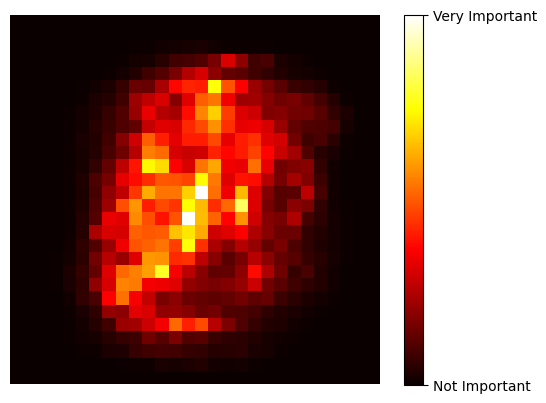

In [ ]:
import matplotlib
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not Important', 'Very Important'])
plt.show()

## 7.5 부스팅 (Boosting)
부스팅은 성능이 **약한 학습기를 여러 개 연결**하여 **강한 학습기를 만드는 앙상블 학습**이다. 부스팅 방법의 아이디어는 **앞에서 학습된 모델을 보완**해나가면서 **더 나은 모델로 학습**시키는 것이다.

부스팅 방법에는 여러 종류가 있는데, 그 중 가장 유명하고 인기 있는 모델은 **에이다부스트**(AdaBoost, Adaptive Boosting)와 **그래디언트 부스팅**(Gradient Boosting) 두 가지가 있다.

### 7.5.1 에이다부스트 (AdaBoost, Adaptive Boosting)
이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 학습 샘플의 가중치를 높이는 것이다. 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.

이처럼 에이다부스트의 방식은 **과소적합되었던 학습 데이터 샘플의 가중치를 높이면서** 새로 학습된 모델이 **학습하기 어려운 데이터에 더 잘 적합되도록** 하는 것이다.

아래의 그림에서처럼 아다부스트의 단계를 설명하면 다음과 같다.
1. 먼저 전제 학습 데이터셋을 이용해 모델을 만든 후, 잘못 예측(분류)된 샘플의 가중치를 상대적으로 높여준다.
2. 그 다음 두번째 모델을 학습시킬 때 이렇게 업데이트된 가중치를 반영하여 모델을 학습시킨다.
3. 이와 같은 과정을 반복한다.

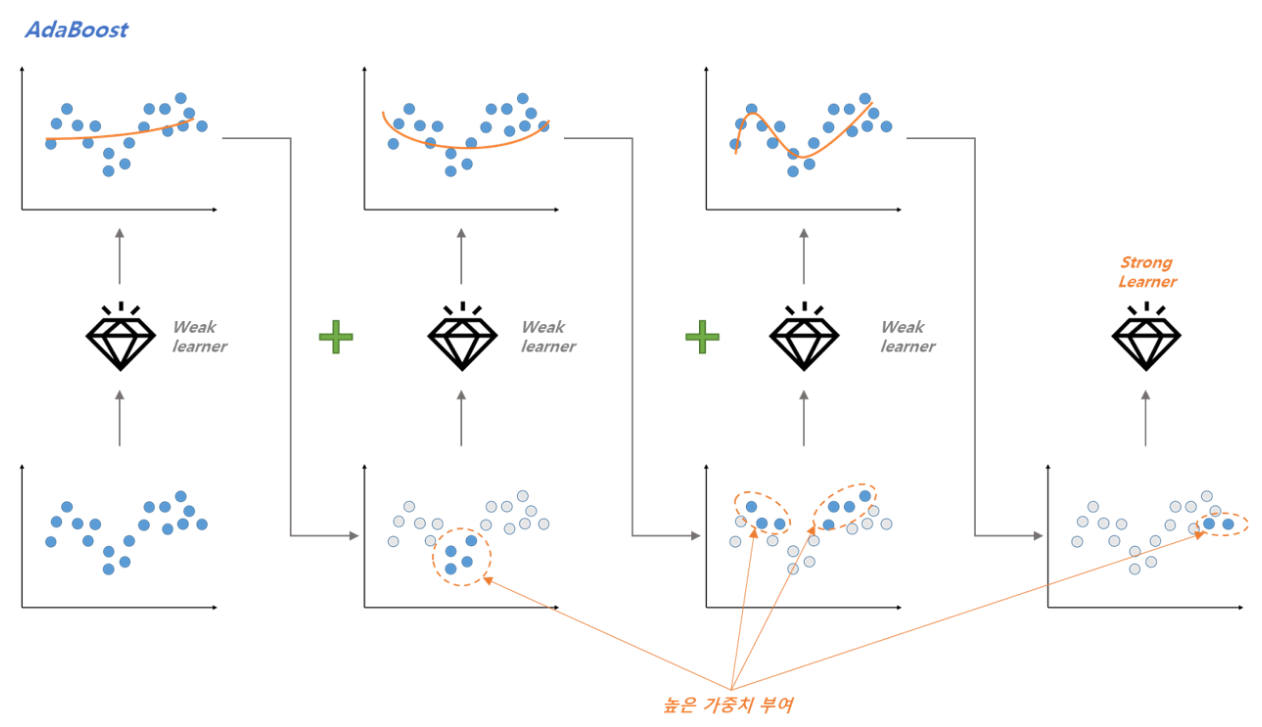

사이킷런은 AdaBoost를 사용할 수 있도록 `AdaBoostClassifier`를 제공한다.

아래의 예제는 moons 데이터셋에 학습시킨 `AdaBoostClassifier` 예측기의 결정 경계를 나타낸 것이다.


In [ ]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

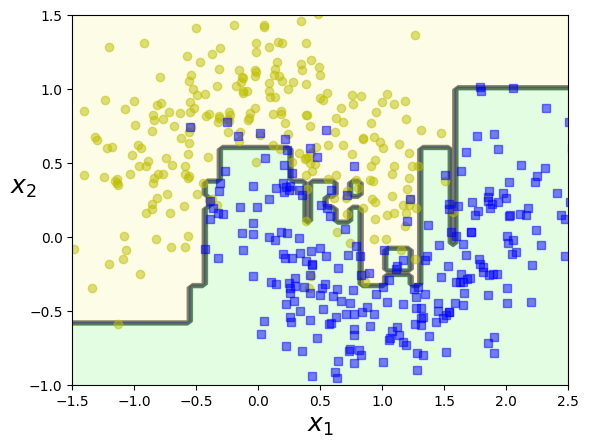

In [ ]:
plot_decision_boundary(ada_clf, X, y)

에이다부스트 알고리즘의 계산 과정을 더 자세하게 살펴본다.

각 샘플 가중치 $w^{(i)}$는 초기에 $\frac{1}{m}$로 초기화된다.

첫번째 예측기가 학습되고, 가중치가 적용된 에러율 $r_1$이 아래의 식을 따라 학습 세트에 대하여 계산된다.

> ***j번째 예측기의 가중치가 적용된 에러율***

$r_j = \frac{\sum_{i=1, {\hat y_j}^{(i)} \neq y^{(i)}}^m w^{(i)}}{\sum_{i=1}^m w^{(i)}}$
- ${\hat y_j}^{(i)}$는 i번째 샘플에 대한 j번째 예측기의 예측

예측기의 가중치 $\alpha_j$는 학습률 하이퍼파라미터인 $\eta$가 포함된 식을 사용하여 계산된다.

> ***예측기 가중치***

$\alpha_j=\eta\log\frac{1-r_j}{r_j}$

이렇게 계산된 **예측기 가중치를 이용**하여 에이다부스트 알고리즘이 **샘플의 가중치를 업데이트**한다. 가중치 업데이트 규칙은 **제대로 분류된 샘플은 그대로 유지**되며, **잘못 분류된 샘플의 가중치는 증가**되는 방식을 따른다

> ***가중치 업데이트 규칙***

$w^{(i+1)} ← \begin{cases} w^{(i)}, &\text{${\hat y_j}^{(i)}=y^{(i)}$} \\ w^{(i)}\exp(\alpha_j), &\text{${\hat y_j}^{(i)}\neq y^{(i)}$} \end{cases} \\ i=1,2,...,m$

그런 다음 모든 샘플의 가중치를 $\displaystyle\sum_{i=1}^m w^{(i)}$로 나눠서 **정규화**한다.

마지막으로 새 예측기가 업데이트된 가중치를 사용하여 훈련되고 전체 과정이 반복된다. 이 과정은 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지된다.

에이다부스트 알고리즘의 예측은 단순히 **모든 예측기의 예측을 계산하고 예측기 가중치 $\alpha_j$를 더하여 예측 결과**를 만든다. 그리고 그 중에서 **가중치 합이 가장 큰 클래스가 예측 결과**가 된다.

> ***에이다부스트 예측***

$\hat y(𝐱) = \arg\max_{k} \displaystyle\sum_{j=1, \hat y_j(𝐱)=k}^{N} \alpha_j \\ N:예측기 수$

사이킷런에서의 `AdaBoostClassifier`는 **SAMME**(Stagewise Additive using a Multiclass Exponential loss function)라는 에이다부스트의 다중 클래스 버전을 사용한다.

SAMME 알고리즘은 위의 AdaBoost 알고리즘과 거의 동일하며,
j번째 모델에 대한 가중치를 계산하는 부분에서의 식이 아래와 같이 다르다.

> ***예측기 가중치***

$\alpha_j=\eta(\log\frac{1-r_j}{r_j}+\log(K-1))\\ K: 클래스 수$

클래스가 2개뿐(K=2)이라면 SAMME는 에이다부스트와 동일하다.

사용하는 예측기가 `predict_proba()`가 있어서 클래스의 확률을 추정할 수 있다면 **SAMME.R**을 사용한다. 이 알고리즘은 예측값 대신 예측 클래스의 확률에 기반하여 모델에 대한 가중치를 계산하고, 일반적으로 성능이 더 좋다. `AdaBoostClassifier`는 default 값으로 SAMME.R이 지정되어 있다.










### 7.5.2 그래디언트 부스팅 (Gradient Boosting)
부스팅의 또 다른 인기 알고리즘으로 **그래디언트 부스팅**(Gradient Boosting)이 있다. 그래디언트 부스팅 **역시 이전의 학습된 모델의 오차를 보완하는 방향**으로 모델(분류기, 학습기)을 추가해주는 방법은 동일하다.

하지만 그래디언트 부스팅은 에이다부스트처럼 학습 단계마다 데이터 샘플의 가중치를 업데이트 해주는 것이 아니라, **학습 전단계 모델에서의 잔여 오차에 대해 새로운 모델을 학습**시키는 방법이다.



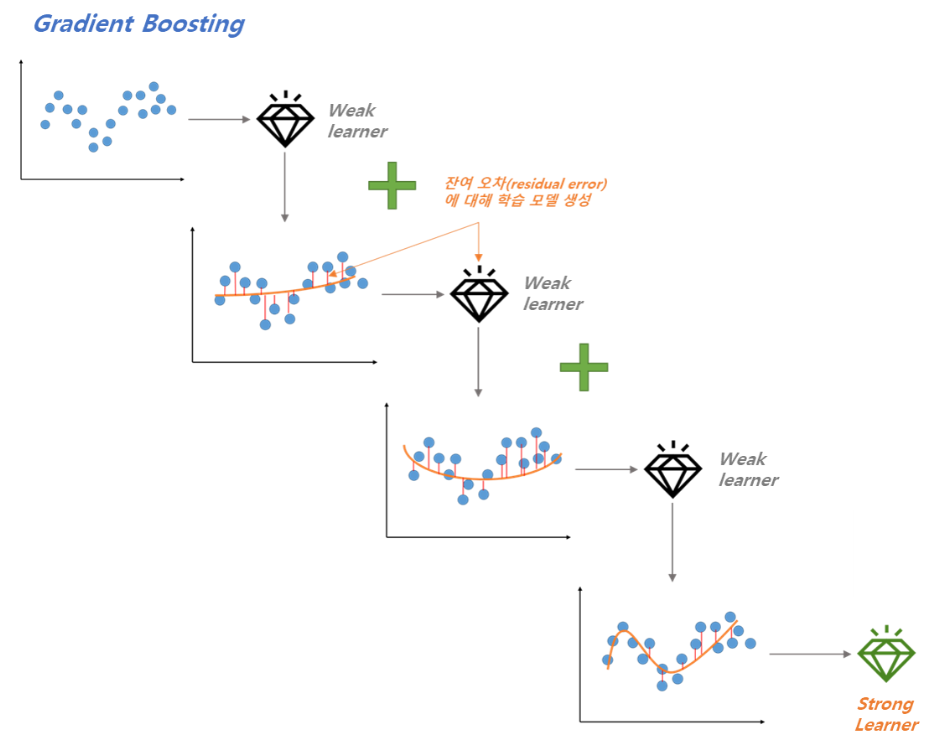

**결정 트리 알고리즘을 기반 예측기**로 이용하여 **회**귀 문제에 대해 그래디언트 부스팅을 사용할 수 있으며, 이를 **그래디언트 트리 부스팅** 또는 **그래디언트 부스티드 회귀 트리(GRBT, Gradient Boosted Regression Tree)**라고 한다.

아래의 예제는 그래디언트 부스팅을 회귀 문제에 적용해 본 예제이다. 예제 데이터의 모양은 다음의 식과 같다. $y=3x^2+0.05+noise$

먼저 잡음이 섞인 2차 곡선 형태의 데이터셋을 생성하고 `DecisionTreeRegressor` 모델을 이 학습 세트에 학습시킨다.



In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

이 첫번째 `DecisionTreeRegressor` 예측기인 tree_reg1에서 생긴 잔여 오차(residual error)를 구하고, 이것을 가지고 두번째 `DecisionTreeRegressor` 모델을 학습시킨다.

In [ ]:
y2 = y - tree_reg1.predict(X) # 잔여 오차
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

위와 같은 방법으로 두번째 모델 tree_reg2에 대한 잔여 오차를 구하여 세번째 모델 tree_reg3을 학습시킨다.

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

이렇게 잔여 오차를 이용하는 방식으로 3개의 트리를 포함하는 앙상블 모델을 만들었다.

새로운 데이터 샘플 X_new = 0.8에 대해 **예측값**을 구하기 위해서는 **모든 트리의 예측을 더하면 된다.**


In [ ]:
X_new = np.array([[0.8]])  # new data

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

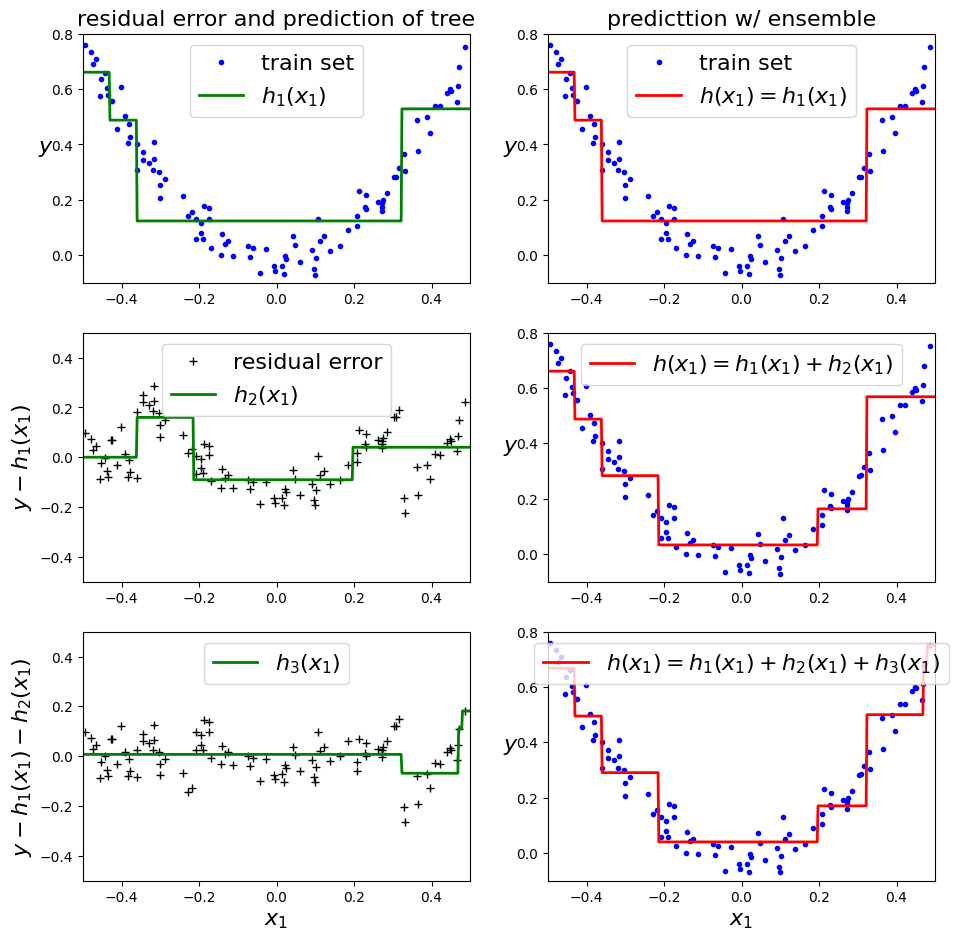

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="train set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("residual error and prediction of tree", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="train set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("predicttion w/ ensemble", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="residual error")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

잔여 오차를 이용하여 3개의 트리를 포함하는 앙상블 모델을 생성하는 과정을 그림으로 나타내면 위와 같다. 왼쪽 열은 3개 트리의 예측이고, 오른쪽 열은 앙상블의 예측이다.

첫번째 행에서는 앙상블에 트리가 하나만 있으므로 첫번째 트리의 예측과 완전히 동일하다.

두번째 행에서는 새로운 트리가 첫번째 트리의 잔여 오차에 대해 학습된다. 따라서 오른쪽의 앙상블 예측은 이 2개 트리의 예측의 합과 같은 것을 볼 수 있다.

비슷하게 세번째 행에서는 또 새로운 트리가 두번째 트리의 잔여 오차에 대해 학습되었고, 오른쪽의 앙상블 예측은 이 3개 트리의 예측의 합과 같다.

트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 확인할 수 있다.

사이킷런의 `GradientBoostingRegressor`를 사용하면 **GBRT 앙상블을 간단하게 훈련**시킬 수 있다.

이 모델은 트리 수(`n_estimators`)와 같이 앙상블의 훈련을 제어하는 매개변수는 물론, `RandomForestRegressor`와 비슷하게 결정 트리의 성장을 제어하는 `max_depth, min_samples_leaf` 매개변수도 가지고 있다.

앞서 `DecisionTreeRegressor`를 이용해 그래디언트 부스팅을 단계별로 수행하여 3개의 트리를 포함하는 앙상블 모델을 만들고, 새로운 데이터 샘플 X_new = 0.8에 대해 구한 예측값은 0.75026781이었다.

아래의 결과에서 볼 수 있듯이, `GradientBoostingRegressor`로 예측한 데이터 샘플 X_new = 0.8에 대해 구한 예측값이 이와 동일한 것을 확인할 수 있다.


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3,
                          random_state=42)

In [ ]:
X_new = np.array([[0.8]])
gbrt.predict(X_new)

array([0.75026781])

`GradientBoostingRegressor`에서 `learning_rate` 인자는 **학습 단계에서 각 모델(트리)의 반영 비율, 즉 기여 정도**를 의미한다.

`learning_rate`의 범위는 $0 \leq \eta \leq 1$이며, **값이 작을수록 학습을 위해 더 많은 모델이 필요**하지만 일반적으로 **예측 성능은 좋아진다.** 이렇게 `learning_rate`를 이용하는 방법이 **축소**(shrinkage)라고 부르는 규제 방법이다.

아래의 예제는 학습시킬 모델의 개수(`n_estimator`)를 3개와 200개로 했을 때의 차이를 나타낸 것이다.

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=200,
                          random_state=42)

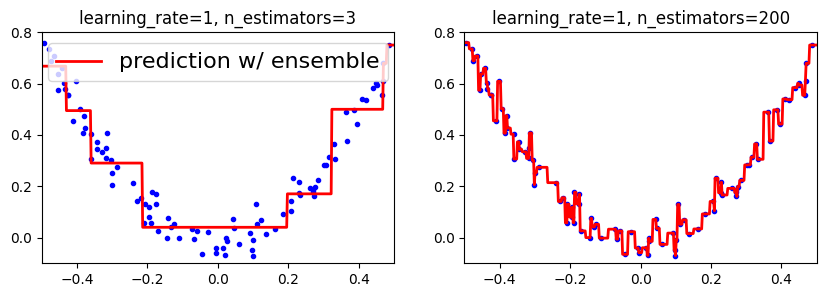

In [ ]:
plt.figure(figsize=(10,3))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="prediction w/ ensemble")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=12)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=12)

plt.show()

왼쪽 그림은 3개의 트리를 사용하였기 때문에 학습 데이터셋을 학습하기에 트리가 충분하지 않아서 좋은 예측을 보이지 못했다.

반면 오른쪽 그림은 200개의 너무 많은 트리를 사용하여 모델이 학습 데이터셋에 과대적합되었다.

그래디언트 부스팅의 학습 단계에서 학습 시킬 **최적의 트리(모델)의 개수**를 찾기 위해 **조기 종료**(early stopping)를 사용할 수 있다.

간단하게 `staged_predict()` 메서드를 사용하면 되는데, 이 메서드는 학습의 **각 단계**에서 **앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환**한다.

먼저 120개의 트리로 GBRT 앙상블을 학습시킨다. 학습된 모델에 `staged_predict()` 메서드를 이용해 각 모델의 예측값(y_pred)과 실제값(y_val)의 MSE를 구한 뒤, MSE가 가장 낮은 최적의 트리의 개수를 찾는다. 그리고 이렇게 찾은 최적의 트리 개수(best_n_estimator)로 다시 그래디언트 부스팅을 학습시키는 예제를 수행하였다.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error
# 최적의 트리 개수 찾기
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors)
best_n_estimators

55

In [ ]:
# 최적의 트리 개수로 그래디언트 부스팅 학습
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=55, random_state=42)

최적의 트리 개수는 55개로, `n_estimators=55`가 되는 GBRT 앙상블을 만들고 학습시킨다.

다음의 왼쪽 그림은 최적의 트리 개수를 찾기 위해 계산한 검증 오차 MSE의 그래프이고, 오른쪽 그림은 이렇게 구한 최적의 트리 개수를 사용한 GBRT 앙상블 모델의 예측 결과이다.



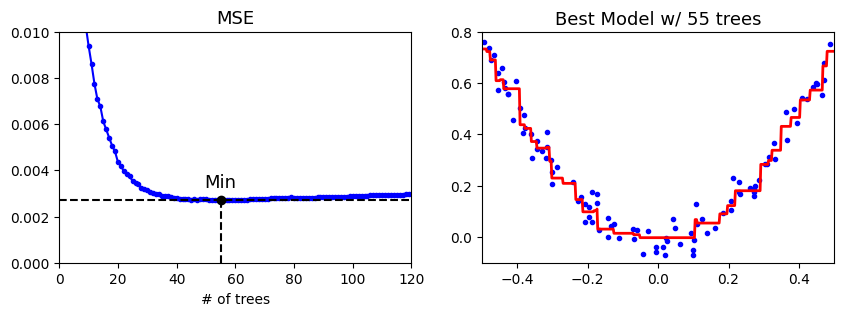

In [ ]:
min_error = np.min(errors)

plt.figure(figsize=(10,3))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Min", ha="center", fontsize=13)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("# of trees")
plt.title("MSE", fontsize=13)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best Model w/ %d trees" % best_n_estimators, fontsize=13)

plt.show()

이렇게 우선 많은 수의 트리를 학습시킨 후의 최적의 트리 개수를 찾는 방법 대신에, 일단 **최적의 트리 개수가 되면 실제로 훈련을 중지**하는 방법으로 조기 종료를 구현할 수도 있다.

`warm_start=True`로 설정하면 사이킷런의 `fit()` 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해준다.

아래의 코드는 연속해서 5번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈춘다. 즉 학습 과정에서 최적의 트리 개수를 찾았을 때 학습을 조기종료 하는 예제이다.

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [ ]:
print('최적의 트리 개수 :', gbrt.n_estimators)
print("최소 검증 MSE:", min_val_error)

최적의 트리 개수 : 61
최소 검증 MSE: 0.002712853325235463


`GradientBoostingRegressor`는 **각 트리가 학습할 때 사용할 훈련 샘플의 비율을 지정**할 수 있는 `subsample` 매개변수도 지원한다.

만약 `subsample=0.25`로 지정한다면, 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습된다. 이렇게 되면 편향은 높아지지만 분산은 낮아지며, 훈련 속도가 상당히 빨라진다. 샘플을 무작위로 선택하게 되므로 이러한 기법을 확률적 그래디언트 부스팅(stochastic gradient boosting)이라고 한다.

최적화된 그래디언트 부스팅 알고리즘의 구현으로 유명한 `XGBoost` 알고리즘이 있다. eXtreme Gradient Boosting의 약자로, 별도의 파이썬 라이브러리를 사용해야 한다.

`XGBoost` API는 사이킷런과 매우 비슷하며, `fit()`으로 학습하고 `predict()`로 예측한다.

또한 여러 가지 좋은 기능을 제공하는데,`early_stopping_rounds`를 지정하여 자동 조기 종료 기능을 사용할 수 있다.

In [ ]:
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [ ]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## 7.6 스태킹 (Stacking)
스태킹(stacking)의 기본 아이디어는 '앙상블에 속한 모든 예측기의 예측을 취합하는 직접 투표 같은 함수를 사용하는 대신에 취합하는 모델 자체를 훈련시킨다'에서 시작한다.

즉 앙상블 학습에서 **각 모델의 예측값을 가지고 새로운 메타 모델(meta learner)을 학습시켜 최종 예측 모델을 만드는 방법**을 말한다.

아래의 그림으로 나타낸 스태킹의 과정은 다음과 같다.
1. 학습 데이터셋에서 샘플링을 통해 서브셋1(subset-1)을 만들고, 이 서브셋을 이용해서 각 모델을 학습시킨다.
2. 이러한 각각의 모델들에 서브셋2(subset-2) 이용해 예측하여 **각 모델의 예측값을 출력하고 예측값들을 합친다.**
3. **합쳐진 예측값들을 입력 특성으로 사용하는 새로운 모델**(meta learner, blender)을 학습시킨다.



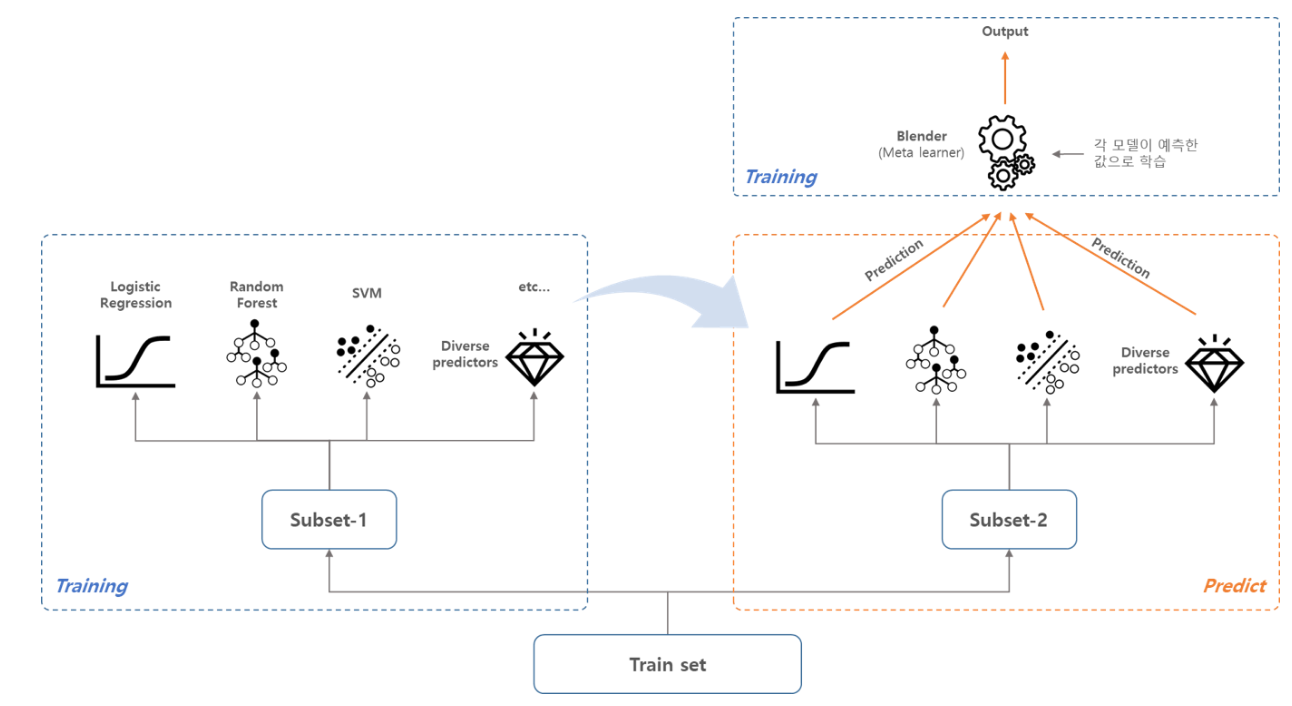